<a href="https://colab.research.google.com/github/PaulToronto/TensorFlow_Tutorials/blob/main/3_Keras_Basic_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras - Basic text classification

- https://tinyurl.com/42fab6rw

## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from textwrap import wrap
import shutil
import re
import string


from tensorflow.keras import layers
from tensorflow.keras import losses

## The IMDB dataset

- this notebook trains a sentiment analysis model to classify reviews as either *positive* or *negative* based on the text of the review
- this is a binary classification problem
- dataset source: https://ai.stanford.edu/%7Eamaas/data/sentiment/
    - 50,000 movie reviews from the Internet Movie Database
    - Split into 25,000 for training and 25,0000 for testing
    - The training and testing sets are **balanced**, meaning they contain and equal number of positive and negative reviews


In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file(fname='aclImdb_v1',
                                  origin=url,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
type(dataset), dataset

(str, './aclImdb_v1')

In [4]:
type(dataset_dir), dataset_dir

(str, './aclImdb')

In [5]:
os.listdir(dataset_dir)

['imdbEr.txt', 'README', 'train', 'test', 'imdb.vocab']

In [6]:
train_dir = os.path.join(dataset_dir,'train')
train_dir

'./aclImdb/train'

In [7]:
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'unsup',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

The `./aclImdb/train/neg` and `./aclImdb/train/pos` directories contain many text files, each of which is a single movie review.

In [8]:
# looking at one of those files
sample_pos_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_pos_file) as f:
    text = f.read()

wrap(text)

['Rachel Griffiths writes and directs this award winning short film. A',
 'heartwarming story about coping with grief and cherishing the memory',
 "of those we've loved and lost. Although, only 15 minutes long,",
 'Griffiths manages to capture so much emotion and truth onto film in',
 'the short space of time. Bud Tingwell gives a touching performance as',
 "Will, a widower struggling to cope with his wife's death. Will is",
 'confronted by the harsh reality of loneliness and helplessness as he',
 "proceeds to take care of Ruth's pet cow, Tulip. The film displays the",
 'grief and responsibility one feels for those they have loved and lost.',
 'Good cinematography, great direction, and superbly acted. It will',
 'bring tears to all those who have lost a loved one, and survived.']

In [9]:
sample_neg_file = os.path.join(train_dir, 'neg/10008_2.txt')
with open(sample_neg_file) as f:
    text = f.read()

wrap(text)

['The film is bad. There is no other way to say it. The story is weak',
 "and outdated, especially for this country. I don't think most people",
 'know what a "walker" is or will really care. I felt as if I was',
 "watching a movie from the 70's. The subject was just not believable",
 'for the year 2007, even being set in DC. I think this rang true for',
 'everyone else who watched it too as the applause were low and quick at',
 "the end. Most didn't stay for the Q&A either.<br /><br />I don't think",
 'Schrader really thought the film out ahead of time. Many of the scenes',
 'seemed to be cut short as if they were never finished or he just',
 "didn't know how to finish them. He jumped from one scene to the next",
 'and you had to try and figure out or guess what was going on. I really',
 "didn't get Woody's (Carter) private life or boyfriend either. What",
 'were all the "artistic" male bondage and torture pictures (from Iraq',
 'prisons) about? What was he thinking? I think it was hi

### Load the dataset

To do this, the `text_dataset_from_directory` utility is used. This utility exepcts a directory structure as follows:

```python
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

In [10]:
# 3 of these are folders: 'neg', 'pos' and 'unsup'
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'unsup',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

To prepare a dataset for binary classification, we need two folders, corrsponding to `class_a` and `class_b` above, so we want to get rid of `unsup`

In [11]:
remove_dir = os.path.join(train_dir, 'unsup')
remove_dir

'./aclImdb/train/unsup'

In [12]:
# shutil recursively deletes a directory "tree"
shutil.rmtree(remove_dir)

In [13]:
os.listdir(train_dir)

['neg',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt']

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [14]:
batch_size = 32
seed = 42       # optional seed for random shuffling
# note, the `shuffle` parameter defaults to True

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [15]:
type(raw_train_ds), raw_train_ds

(tensorflow.python.data.ops.prefetch_op._PrefetchDataset,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

You can train a model by passing the dataset directly into the `model.fit()` method. First let's have a look at the data.

In [16]:
test = raw_train_ds.take(1)

for a, b in test:
    print(type(a))
    print(type(b))

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [17]:
for a, b in test:
    print(a.numpy())
    print(len(a.numpy()))       # batch size
    print('\n______________\n')
    print(b.numpy())
    print(len(b.numpy()))       # batch size

[b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
 b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<br /><br />As I\'m s

In [18]:
for a, b in test:
    for i in range(3):
        print(a.numpy()[i])
        print(b.numpy()[i])
        print('\n________\n')

b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a mysteri

In [19]:
# each time `.take()` is called, a pointer is moved forward
#. her were want to refresh the data to bring the pointer back to 0
batch_size = 32
seed = 42       # optional seed for random shuffling
# note, the `shuffle` parameter defaults to True

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [20]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

#### The classes

The labels are 0 and 1. How do these correspond to the sentiment of movie reviews?

In [21]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


### Test and Validation sets

- We will use the remaining 5,000 reviews from the training set for validation

#### IMPORTANT NOTE:

When using the validation_split and subset arguments, make sure to either specify a random `seed`, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [22]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',    # this is the only arg that changed
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [23]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

#### List of things to do:

1. **Standardize**: preprocess the text, typically to remove punctuation or HTML
2. **Tokenize**: split the strings into *tokens* (example: splitting a sentence into individual words by splitting on whitespace)
3. **Vectorize**: convert tokens into numbers so they can be fed ito a neural network

All of these tasks can be completed using the `tf.keras.layers.TextVectorization` layer.

- The default standardizer in this layer only converts text to lowercase and strips punctuation. We need a custom standardization functiom to removee the HTML
- **Note**:To prevent training-testing skew (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.
    - https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew

#### Custom standardizer

In [24]:
input_data_sample = text
input_data_sample

'The film is bad. There is no other way to say it. The story is weak and outdated, especially for this country. I don\'t think most people know what a "walker" is or will really care. I felt as if I was watching a movie from the 70\'s. The subject was just not believable for the year 2007, even being set in DC. I think this rang true for everyone else who watched it too as the applause were low and quick at the end. Most didn\'t stay for the Q&A either.<br /><br />I don\'t think Schrader really thought the film out ahead of time. Many of the scenes seemed to be cut short as if they were never finished or he just didn\'t know how to finish them. He jumped from one scene to the next and you had to try and figure out or guess what was going on. I really didn\'t get Woody\'s (Carter) private life or boyfriend either. What were all the "artistic" male bondage and torture pictures (from Iraq prisons) about? What was he thinking? I think it was his very poor attempt at trying to create this d

In [25]:
lowercase = tf.strings.lower(input_data_sample)
lowercase.numpy() # converts EagerTensor to bytes string literal

b'the film is bad. there is no other way to say it. the story is weak and outdated, especially for this country. i don\'t think most people know what a "walker" is or will really care. i felt as if i was watching a movie from the 70\'s. the subject was just not believable for the year 2007, even being set in dc. i think this rang true for everyone else who watched it too as the applause were low and quick at the end. most didn\'t stay for the q&a either.<br /><br />i don\'t think schrader really thought the film out ahead of time. many of the scenes seemed to be cut short as if they were never finished or he just didn\'t know how to finish them. he jumped from one scene to the next and you had to try and figure out or guess what was going on. i really didn\'t get woody\'s (carter) private life or boyfriend either. what were all the "artistic" male bondage and torture pictures (from iraq prisons) about? what was he thinking? i think it was his very poor attempt at trying to create this 

In [26]:
stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
stripped_html.numpy()

b'the film is bad. there is no other way to say it. the story is weak and outdated, especially for this country. i don\'t think most people know what a "walker" is or will really care. i felt as if i was watching a movie from the 70\'s. the subject was just not believable for the year 2007, even being set in dc. i think this rang true for everyone else who watched it too as the applause were low and quick at the end. most didn\'t stay for the q&a either.  i don\'t think schrader really thought the film out ahead of time. many of the scenes seemed to be cut short as if they were never finished or he just didn\'t know how to finish them. he jumped from one scene to the next and you had to try and figure out or guess what was going on. i really didn\'t get woody\'s (carter) private life or boyfriend either. what were all the "artistic" male bondage and torture pictures (from iraq prisons) about? what was he thinking? i think it was his very poor attempt at trying to create this dark priva

In [27]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [28]:
# removes puncuation
tf.strings.regex_replace(stripped_html,
                         '[%s]' % re.escape(string.punctuation),
                         '').numpy()

b'the film is bad there is no other way to say it the story is weak and outdated especially for this country i dont think most people know what a walker is or will really care i felt as if i was watching a movie from the 70s the subject was just not believable for the year 2007 even being set in dc i think this rang true for everyone else who watched it too as the applause were low and quick at the end most didnt stay for the qa either  i dont think schrader really thought the film out ahead of time many of the scenes seemed to be cut short as if they were never finished or he just didnt know how to finish them he jumped from one scene to the next and you had to try and figure out or guess what was going on i really didnt get woodys carter private life or boyfriend either what were all the artistic male bondage and torture pictures from iraq prisons about what was he thinking i think it was his very poor attempt at trying to create this dark private subculture life for woodys character

In [29]:
# putting it all together in a function
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

# test function
custom_standardization(input_data_sample).numpy()

b'the film is bad there is no other way to say it the story is weak and outdated especially for this country i dont think most people know what a walker is or will really care i felt as if i was watching a movie from the 70s the subject was just not believable for the year 2007 even being set in dc i think this rang true for everyone else who watched it too as the applause were low and quick at the end most didnt stay for the qa either  i dont think schrader really thought the film out ahead of time many of the scenes seemed to be cut short as if they were never finished or he just didnt know how to finish them he jumped from one scene to the next and you had to try and figure out or guess what was going on i really didnt get woodys carter private life or boyfriend either what were all the artistic male bondage and torture pictures from iraq prisons about what was he thinking i think it was his very poor attempt at trying to create this dark private subculture life for woodys character

#### `TextVectorization` layer

- This is the layer that is used to standardize, tokenize and vectorize the data
- Arguments used:
    - **standardize**: our `custom_standardization` function
    - **split**: we leave it as the default which is `"whitespace"`
    - **max_tokens**: maximum size of the vocabulary for this layer
    - **output_mode**: `"int"`: Outputs integer indices, one integer index per split string token. When output mode is `"int"`, 0 is reserved for masked locations; this reduces the vocab size to `max_tokens - 2` instead of `max_tokens - 1`
    - **output_sequence_length**: only valide in INT mode. If set, the output will have its time dimension padded or truncated to exactly `output_sequence_length`, regardless of how many tokens resulted from the splitting step.

In [30]:
max_features = 10_000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer

<TextVectorization name=text_vectorization, built=False>

In [31]:
print(type(vectorize_layer))

<class 'keras.src.layers.preprocessing.text_vectorization.TextVectorization'>


##### `.adapt()` method

- What Happens When You Call adapt():
    - The TextVectorization layer reads through the text_data.
    - It tokenizes the text (e.g., splits sentences into words).
    - It builds a vocabulary of the most common tokens (up to max_tokens if specified).
    - The layer internally stores the token-to-index and index-to-token mappings.
    - **Note: It's important to only use your training data when calling adapt (using the test set would leak information),**


In [32]:
raw_train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
# make a text only dataset (without the labels)
# `.map`: Maps `map_func` across the elements of this dataset.
train_text = raw_train_ds.map(lambda x, y: x)

In [34]:
for item in raw_train_ds.as_numpy_iterator():
    print(item) # label is still here
    break

(array([b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up.",
       b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<br /><

In [35]:
for item in train_text.as_numpy_iterator():
    print(item)
    break

[b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a myster

In [36]:
# UNK is for an unknown word that doesn't exist in the vocabulary set
vectorize_layer.get_vocabulary()

['', '[UNK]']

In [37]:
# the adapt method
vectorize_layer.adapt(train_text)

In [38]:
# notice the change due to calling the .adapt() method
vectorize_layer.get_vocabulary()[:25]

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'you',
 'are',
 'his']

##### Looking at the result of using the `TextVectorization` layer

First we create a function to see the result

In [39]:
def vectorize_text(text, label):
    # This is necessary because the TextVectorization layer
    # typically expects a 2D tensor (batch size, sequence length)
    # where each row corresponds to a single text example.
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

- `next()` is a built-in Python function that returns the next item from the iterator
- `iter()` is a built-in Python function that gets an iterator from an object

In [40]:
text_batch, label_batch = next(iter(raw_train_ds))

In [41]:
print(text_batch)
print('\n')
print(label_batch)

tf.Tensor(
[b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'
 b'Wow. The only people reviewing this positively are the Carpenter apologists. I know a lot of those. The guys that\'ll watch John Carpenter squat on celluloid and pinch out a movie and proclaim it a masterwork of horror. This "m

In [42]:
first_review, first_label = text_batch[0], label_batch[0]

In [43]:
first_review

<tf.Tensor: shape=(), dtype=string, numpy=b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'>

In [44]:
first_label

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [45]:
raw_train_ds.class_names[first_label]

'neg'

In [46]:
first_review.shape, tf.expand_dims(first_review, -1).shape

(TensorShape([]), TensorShape([1]))

In [47]:
tf.expand_dims(first_review, -1)

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)'],
      dtype=object)>

In [48]:
# now we use our function
first_review_vectorized, first_label_vectorized = vectorize_text(first_review, first_label)

In [49]:
first_review_vectorized

<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,   86, 1011,   67,    1,
        1707,   18,  128,   27,    7,  688, 2396,    3,   84,    5,   12,
          27, 1453,   24,  616, 3314,   27,  261,    6,    2,    1, 1329,
           5, 1371,    3,    1, 1581,   15,   46, 1356, 3612,   56,   46,
          79,  201,    2, 1356,  261,    6,   50,    1, 1329, 1581,   15,
          50, 1356, 3612,   56,   50,   79,  532,    2,  211,   17,    7,
        2851,  101, 2851,  101, 2851,    9,  180,   12,    2,   79,   36,
          90,    9,   66,   57,   78, 5415,   70,    6,  916,    2,  800,
        4891,    5, 1678, 1347,    1,   36,   13, 1732,  128,  120, 3078,
          46,   49, 3274,   31,    2,  435,  948,   35,  143, 3519,    1,
           7,    4, 1097, 9578, 3092, 2056,    3, 2512, 1021,   17, 1105,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [50]:
first_label_vectorized

<tf.Tensor: shape=(), dtype=int32, numpy=0>

Each token has been replaced by an integer. You can look up the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer

In [51]:
vectorize_layer.get_vocabulary()[1488]

'henry'

In [52]:
len(vectorize_layer.get_vocabulary()) # same as max_features

10000

In [53]:
sum(first_review_vectorized.numpy()[0] != 0)

132

In [54]:
len(first_review.numpy().split()) # close to above

133

##### Apply the `TextVectorization` layer to the train, validation and test dataset

In [55]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

#### Configure the dataset for performance

- There are 2 important methods you should use when loading data to make sure that I/0 does not become blocking:
    1. `.cache()`:
        - keeps data in memory after it's loaded off disk
        - ensures the dataset does not become a bottleneck while training your model
        - if your dataset is too large to fit in memory, you can also use this method to create a performan on-disk cache, which is more efficient to read than many files
    2. `.prefetch()`
        - overlaps data preprocessing and model execution while training

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

In [57]:
AUTOTUNE
# integer used for the buffer size in `.prefetch()`

-1

In [58]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

It's time to create the neural network.

In [59]:
embedding_dim = 16

In [60]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2), # helps prevent overfitting
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Compile the model

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the mout outputs a probability (a single output layer with sigmoid activation), we use the `losses.BinaryCrossentropy` loss function.

In [61]:
model.compile(loss=losses.BinaryCrossentropy,
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

## Train the model

`validation_data`: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

In [62]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - binary_accuracy: 0.5841 - loss: 0.6819 - val_binary_accuracy: 0.7234 - val_loss: 0.6125
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - binary_accuracy: 0.7623 - loss: 0.5776 - val_binary_accuracy: 0.8072 - val_loss: 0.4931
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8247 - loss: 0.4630 - val_binary_accuracy: 0.8394 - val_loss: 0.4185
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - binary_accuracy: 0.8523 - loss: 0.3927 - val_binary_accuracy: 0.8556 - val_loss: 0.3749
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8673 - loss: 0.3477 - val_binary_accuracy: 0.8628 - val_loss: 0.3475
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8762 - loss: 0.3158 - val_binary_accuracy: 0.8688 - val_loss: 0.3282
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - binary_accuracy: 0.8898 - loss: 0.2900 - val_binary_accuracy: 0.8728 - val_loss: 0.3149
Epo

## Evaluate the model

In [63]:
loss, accuracy = model.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8738 - loss: 0.3137


In [64]:
loss

0.31436121463775635

In [65]:
accuracy

0.8726800084114075

### Create a polot of accuracy and loss over time

In [66]:
# `model.fit()` returns a History object
history_dict = history.history

In [67]:
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

In [68]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [69]:
epochs = range(1, len(acc) + 1)
epochs

range(1, 11)

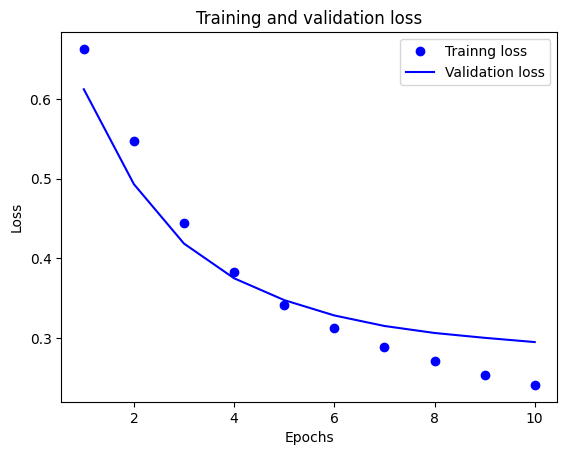

In [70]:
# 'bo' is for 'blue dot'
plt.plot(epochs, loss, 'bo', label='Trainng loss')
# 'b' is for 'solid blue line'
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

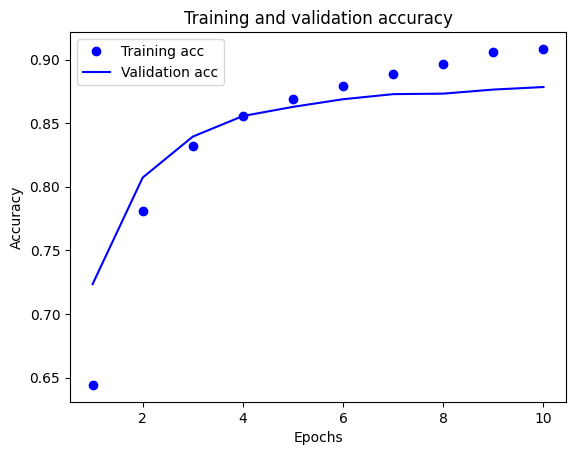

In [71]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Notice that the validation loss and accuracy. The validation accuracy seems to peak before the training accuracy. This is an example of **overfitting**. The model performs better on the training data than it does on data it has never seen before. In this particular case, you could prevent overfitting by simply stopping the training when teh validation accuracy is no longer increasing. One way to do this is to use the `tf.keras.callbaks.EarlyStopping` callback.

## Export the model

In the code above, the `TextVectorization` layer was applied to the data before feeding text to the model. In order to make the model capable of processing raw strings (which would simplify deployment), the `TextVectorization` layer needs to be included inside the model.

In [72]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  # this line was in the tutorial, but I don't understand it and
  #. it made the model much worse, seems redundant to me
  #layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer="adam",
    # from the tutorial, but I changed it
    # metrics=['accuracy']
    metrics = [tf.metrics.BinaryAccuracy(threshold=0.5)]
)

# Test it with `raw_test_ds`, which yields raw strings
export_model.evaluate(raw_test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - binary_accuracy: 0.8738 - loss: 0.0000e+00


[0.0, 0.0, 0.8726800084114075, 0.8726800084114075]

## Inference on new data

In [73]:
# tf.constant creates a constant tensor
examples = tf.constant([
    'The movie was great!',
    'The movie was okay.',
    'The movie was terrible...'
])

examples

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'The movie was great!', b'The movie was okay.',
       b'The movie was terrible...'], dtype=object)>

In [74]:
# trying it with the original model, not sure if this is correct
model.predict(vectorize_text(examples, None)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([[0.61469215],
       [0.4311162 ],
       [0.33864084]], dtype=float32)

In [75]:
export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


array([[0.61469215],
       [0.4311162 ],
       [0.33864084]], dtype=float32)

## Further Study

I found this tutorial difficult to fully understand, probably because I know so little about text classification. This "Text classification guide" from Google Developers might help:

https://developers.google.com/machine-learning/guides/text-classification/

